### Problem: Can we create a machine learning model to read an image of a chess board and convert it to the board's FEN?

In [66]:
import glob
import pandas as pd 
import numpy as np
from numpy import random
from random import sample


from sklearn.metrics import classification_report
from skimage.util.shape import view_as_blocks
from skimage import io, transform

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.preprocessing.image import load_img
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical

import matplotlib.pyplot as plt

import re
import os

import warnings
warnings.filterwarnings('ignore')
#imports

### Our data was downloaded from Kaggle, a train set folder of 20,000 images, and a test set folder of 80,000 images

In [2]:
test_board = plt.imread('dataset/test/1b1B1Qr1-7p-6r1-2P5-4Rk2-1K6-4B3-8.jpeg');

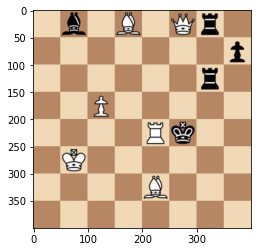

In [3]:
plt.imshow(test_board); #example image

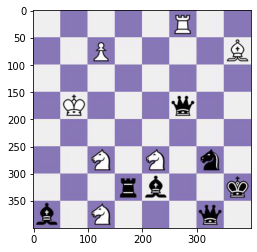

In [4]:
test_board = plt.imread('dataset/test/5R2-2P4B-8-1K3q2-8-2N1N1n1-3rb2k-b1N3q1.jpeg');
plt.imshow(test_board); #no two board are identical, position, color, and chess piece visuals are unique 

In [5]:
train = glob.glob("dataset/train/*.jpeg") #convert file path to strings
test = glob.glob("dataset/test/*.jpeg")
train = sample(train, 10_000) #sample 10_000 random train strings
test = sample(test, 3_333) #sample 3_333 random test strings

#glob.glob found here https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/
#using '*' as a wildcard we are able to turn every single file path from our dataset into a string

In [6]:
train[:5]

['dataset/train/R3q3-8-5k2-n7-8-3Q2pb-3K1P2-6N1.jpeg',
 'dataset/train/5K2-rP6-3b4-N7-5n2-p3p3-n2n3N-q5kr.jpeg',
 'dataset/train/8-7k-2K5-8-N2np3-1Bn5-1n6-8.jpeg',
 'dataset/train/8-8-2K3Pk-B7-8-3p4-8-8.jpeg',
 'dataset/train/6k1-4r3-5b2-3K4-5N2-3N4-P7-3r3b.jpeg']

In [7]:
test[:5]

['dataset/test/8-7r-2K4k-7r-8-R7-8-4R3.jpeg',
 'dataset/test/b7-1n1K1k2-2r5-8-r2B4-3n4-b7-7r.jpeg',
 'dataset/test/3q4-1P6-1P2bK2-8-1r4Pk-1P6-6qB-7B.jpeg',
 'dataset/test/8-2NK3R-2p1Q3-5n2-1B4k1-8-7b-1N6.jpeg',
 'dataset/test/K3b3-2R1B1N1-5k2-1P6-1N2P3-1Q4n1-B6p-7R.jpeg']

### Creating a function to extract the fen from the filename

In [8]:
def extract_fen_from_file(file):
    file = file.split('/')[-1] #we split the string at the '/' and simply take the FEN
    file = file.replace('.jpeg', '') #we drop the .jpeg
    return file

In [9]:
print(extract_fen_from_file(train[0]))
print(extract_fen_from_file(test[0])) #works well!

R3q3-8-5k2-n7-8-3Q2pb-3K1P2-6N1
8-7r-2K4k-7r-8-R7-8-4R3


In [10]:
pieces = 'prbnkqPRBNKQ_' #the notation of pieces that we will use, lowercase are black pieces, upercase are white pieces, '_' is an empty space on the board

### Function to create a matrix/array from FEN

In [11]:
# Demonstrating first part of function to create a list that represents a chessboard from a FEN
def matrix_from_fen_part_1(fen):
    array = []
    rows = fen.split('-') #split the fen into 8 parts, one for each row in the board
    for row in rows:
        for char in row:
            if char.isdigit():
                array += ['_'] * int(char) #if the character is a number, add that many empty spaces
            else:
                array.append(char) #otherwise add the character
    return array

In [12]:
print(matrix_from_fen_part_1(extract_fen_from_file(train[0]))) #our demonstration works, we have a list that represent a full chess board, read top to bottom
print(len(matrix_from_fen_part_1(extract_fen_from_file(train[0])))) #length of 64, 8x8, each board space

['R', '_', '_', '_', 'q', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'k', '_', '_', 'n', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'Q', '_', '_', 'p', 'b', '_', '_', '_', 'K', '_', 'P', '_', '_', '_', '_', '_', '_', '_', '_', 'N', '_']
64


In [13]:
def matrix_from_fen(fen):
    array = []
    rows = fen.split('-') 
    for row in rows:
        for char in row:
            if char.isdigit():
                array += ['_'] * int(char) 
            else:
                array.append(char) 
    
    matrix = np.array([pieces.index(i) for i in array]) #convert list to a numpy array based on our pieces index
    
    matrix = to_categorical(matrix, num_classes = 13) #convert array of integers to binary, (all 0's and 1's), since we have 12 possible pieces and an empty space, it will be shape (64, 13)
                                                      #we want 13 classes for the 13 possible pieces(and lack of piece)  
    return matrix

# to categorical found here ---> 'https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical'

In [14]:
matrix_from_fen(extract_fen_from_file(train[0]))

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 

In [15]:
len(matrix_from_fen(extract_fen_from_file(train[0]))) 

64

In [16]:
matrix_from_fen(extract_fen_from_file(train[0])).shape 

(64, 13)

In [17]:
matrix_from_fen(extract_fen_from_file(train[0]))[:8]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
      dtype=float32)

In [18]:
print(extract_fen_from_file(train[0]).split('-')[0]) #works well, matches first row

R3q3


### Function to later convert a matrix back to FEN

In [19]:
def fen_from_matrix(matrixed_fen):
    
    output = ''
    s = []
    q = []
    
    for j in range(64):
        for i in range(12,13):
            if(matrixed_fen[j][i] == 1.):
                output += '1'             #if a matrix row ends in a 1 it's an empty space, append a value of '1'         
        for i in range(12):
            if(matrixed_fen[j][i] == 1.):
                output += pieces[i]       #for all other rows in a matrix, append the corresponding indexed piece
        
    output = [output[i:i+8] for i in range(0, len(output), 8)] #split the string into 8 parts, one for each row
    
    for i in range(len(output)):
        s.append(re.split('(\d+)', output[i])) #split the string so the 1's will be separated from the piece symbols
                                               # found re function here --> https://stackoverflow.com/questions/3340081/product-code-looks-like-abcd2343-what-to-split-by-letters-and-numbers
    
    try:
        
        for i in range(len(s)):
            if s[i][-1].endswith(('p', 'r', 'b', 'n', 'k', 'q', 'P', 'R', 'B', 'N', 'K', 'Q')) and s[i+1][0].endswith(('p', 'r', 'b', 'n', 'k', 'q', 'P', 'R', 'B', 'N', 'K', 'Q')):
                s[i].append('')
    
    except IndexError:
        
        pass                      #for this loop, we need to add an empty '' if needed, at the end of every row, otherwise our rows may not separate properly in cases where
                                  #a row ends with a character and the next row starts with a character
    
    for i in range(len(s)):
        for j in s[i]:
            try:
                q.append(int(j))
            except:
                q.append(j)       #turning the list into a string with the 1's as integers
                
    fen = [len(str(i)) if type(i) == int else i for i in q] #convert the numbers to their length, this will be consecutive empty spaces in a row, i.e. 111 = 3 empty spaces
    
    fen = ['-' if i == '' else i for i in fen] #convert the quotes into dashes, this will separate out rows from eachother
    
    fen = [str(i) if type(i) == int else i for i in fen] #convert numbers back to string
    
    fen = ''.join(fen) #join elements
    
    fen = fen.replace('--', '-') #if there are two dashes, replace with one
    
    if '7r' or '7R' or '7n' or '7N' or '7b' or '7B' or '7q' or '7Q' or '7k' or '7K' or '7p' or '7P' in fen:
        
        fen = fen.replace('7r', '7r-')
        fen = fen.replace('7R', '7R-')
        fen = fen.replace('7n', '7n-')
        fen = fen.replace('7N', '7N-')
        fen = fen.replace('7b', '7b-')
        fen = fen.replace('7B', '7B-')
        fen = fen.replace('7q', '7q-')
        fen = fen.replace('7Q', '7Q-')
        fen = fen.replace('7k', '7k-')
        fen = fen.replace('7K', '7K-')
        fen = fen.replace('7p', '7p-')
        fen = fen.replace('7P', '7P-')
    
    if 'r7' or '7R' or 'n7' or 'N7' or 'b7' or 'B7' or 'q7' or 'Q7' or 'k7' or 'K7' or 'p7' or 'P7' in fen:
        
        fen = fen.replace('r7', '-r7')
        fen = fen.replace('R7', '-R7')
        fen = fen.replace('n7', '-n7')
        fen = fen.replace('N7', '-N7')
        fen = fen.replace('b7', '-b7')
        fen = fen.replace('B7', '-B7')
        fen = fen.replace('q7', '-q7')
        fen = fen.replace('Q7', '-Q7')
        fen = fen.replace('k7', '-k7')
        fen = fen.replace('K7', '-K7')
        fen = fen.replace('p7', '-p7')
        fen = fen.replace('P7', '-P7')
        
    #When the length of empty spaces is 7, our string is not separated properly, this fixes every possible case of 7 empty spaces followed by a piece and vice versa
        
    if fen.startswith('-') == True and fen.endswith('-') == True:
        fen = fen[1:-1]
    elif fen.startswith('-') == True:
        fen = fen[1:]
    elif fen.endswith('-') == True:
        fen = fen[:-1]
    else: fen = fen
    
    #removing dashes in the front/end of our string
    
    fen = fen.replace('--', '-') 
    
    #removing duplicate dashes once more
    
    fen = fen.replace('--', '-') 
    # we have to do it again for some reason!

    return fen

In [20]:
fen_from_matrix(matrix_from_fen(extract_fen_from_file(train[0]))) == extract_fen_from_file(train[0]) #it works!

True

In [21]:
fen_from_matrix(matrix_from_fen(extract_fen_from_file(test[0]))) == extract_fen_from_file(test[0])

True

In [22]:
fen_from_matrix(matrix_from_fen(extract_fen_from_file(train[22])))

'3K4-1P6-8-7R-3k4-8-2p1b1P1-B7'

In [23]:
 extract_fen_from_file(train[22])

'3K4-1P6-8-7R-3k4-8-2p1b1P1-B7'

In [24]:
acc = []
for i in range(len(train)):
    if fen_from_matrix(matrix_from_fen(extract_fen_from_file(train[i]))) == extract_fen_from_file(train[i]):
        acc.append('NICE')
    else:
        acc.append('No!')
acc = pd.DataFrame(acc)
acc[0].value_counts() #works perfectly!

NICE    10000
Name: 0, dtype: int64

### Processing the Image

In [25]:
def process_image(img):
    square_size = int(240/8) #our square size is (240 pixels divided by 8, 240 pixels divided by 8) since we have 64 squares. Our image size has to be divisible by 8 to avoid floats in pixels.
    img_read = io.imread(img) #skimage reads an image from a file --> https://scikit-image.org/docs/dev/api/skimage.io.html
    img_read = transform.resize(img_read, (240, 240), mode = 'constant') #resize the image to desired size, (240, 240 pixels) mode = 'constant' fills outside of boundaries with a constant value
                                                                         # found ---> https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
    squares = view_as_blocks(img_read, block_shape = (square_size, square_size, 3)) #we make image squares for each square on the board, 64 total tiles
    squares = squares.squeeze(axis = 2) #removes an extra dimension at axis = 2 that was created from previous step
    squares = squares.reshape(64, square_size, square_size, 3) #we reshape our tiles into appropriate size for modeling, 64 squares, 30 pixels height/width, 3 dimensions
    return squares 

#this function was inspired from --> https://www.kaggle.com/koryakinp/chess-fen-generator

In [26]:
process_image(test[0])

array([[[[0.82091503, 0.84836601, 0.8875817 ],
         [0.83529412, 0.8627451 , 0.90196078],
         [0.8379085 , 0.86535948, 0.90457516],
         ...,
         [0.83660131, 0.86405229, 0.90326797],
         [0.83398693, 0.86405229, 0.90065359],
         [0.82309368, 0.87320261, 0.90588235]],

        [[0.82875817, 0.85620915, 0.89542484],
         [0.84313725, 0.87058824, 0.90980392],
         [0.84575163, 0.87320261, 0.9124183 ],
         ...,
         [0.83921569, 0.86666667, 0.90588235],
         [0.83529412, 0.86666667, 0.90196078],
         [0.82222222, 0.87320261, 0.90457516]],

        [[0.83224401, 0.85969499, 0.89891068],
         [0.84313725, 0.87058824, 0.90980392],
         [0.84662309, 0.87407407, 0.91328976],
         ...,
         [0.84313725, 0.87058824, 0.90980392],
         [0.83921569, 0.86666667, 0.90588235],
         [0.8130719 , 0.86405229, 0.89542484]],

        ...,

        [[0.84313725, 0.87058824, 0.90980392],
         [0.85098039, 0.87843137, 0.91764706]

### Train Generator Function to fit into Machine Learning Model

In [27]:
def train_generator(train, batch_size): #we are using our sampled training data and a batch size of 64 for the 64 squares in a board
    for image in train:
        x = process_image(image) #process every image from train for our x variable
        y = matrix_from_fen(extract_fen_from_file(image)) #extract the fen from the file for our y variable
        yield x, y #we use yield instead of return to produce a sequence of values, we're iterating over our values!

In [28]:
process_image(train[0]).shape

(64, 30, 30, 3)

### Machine Learning Model

In [29]:
model = Sequential() #basic cnn model using convolution layers, maxpooling with appropriate shapes

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (30, 30, 3))) #input size of each square

model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPool2D())


model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPool2D())
model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.4))

model.add(Dense(13, activation = 'softmax')) #softmax works the best here, final dense layer of 13 for each possible piece
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

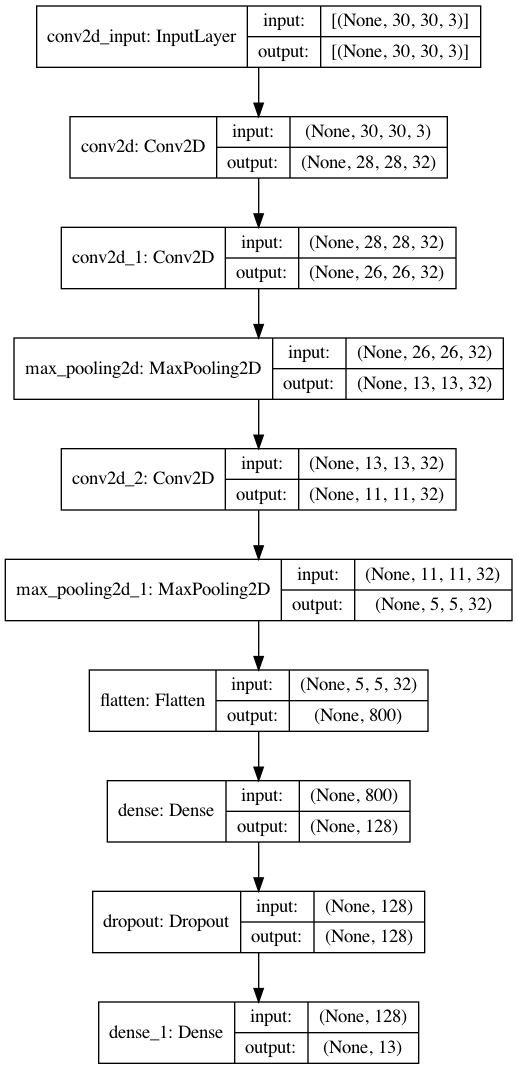

In [30]:
plot_model(model, to_file = 'model_viz.png', show_shapes = True, show_layer_names = True)

In [31]:
history = model.fit_generator(train_generator(train, 64), steps_per_epoch = 10_000) #batches of 64 for a full board, 1 epoch step for each train file

10000/10000 [==============================] - 643s 64ms/step - loss: 0.1180 - accuracy: 0.9729


In [53]:
history.history

{'loss': [0.03264961764216423], 'accuracy': [0.9917890429496765]}

In [54]:
model.save("model.h5")

### Predictions

In [55]:
pred_1 = model.predict(process_image(train[0])) #predict the matrix from the image
fen_1 = fen_from_matrix(np.round(pred_1)) #Convert the matrix to FEN, we round to get a FEN matrix from our prediction

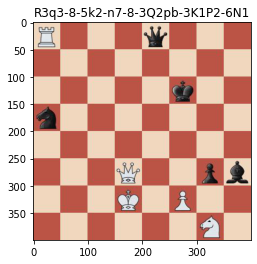

In [56]:
plt.title(fen_1)
plt.imshow(plt.imread(train[0])); #matches!

In [57]:
def image_with_predicted_FEN(image): #function to plot image and display predicted FEN
    pred = model.predict(process_image(image))
    fen = fen_from_matrix(np.round(pred))
    plt.title(fen)
    plt.imshow(plt.imread(image)); 

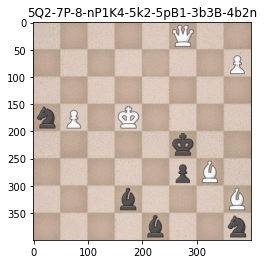

In [58]:
image_with_predicted_FEN(train[345]) #matches

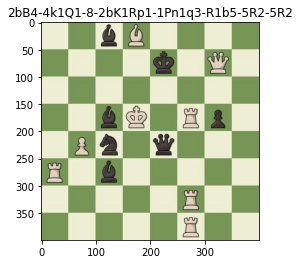

In [59]:
image_with_predicted_FEN(train[random.randint(10_000)]) #matches on random train

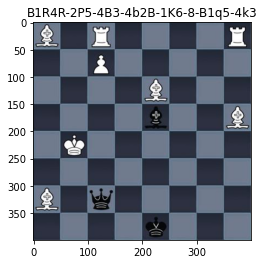

In [60]:
image_with_predicted_FEN(test[random.randint(3_333)]) #matches on random test

### Overall Accuracy from Test Set

In [61]:
pred_fens = []
true_fens = []
for i in range(len(test)):
    
    pred = model.predict(process_image(test[i]))
    fen = fen_from_matrix(np.round(pred))
    pred_fens.append(fen)
    
    true_fens.append(extract_fen_from_file(test[i]))

In [62]:
preds_df = pd.DataFrame(true_fens)
preds_df['pred_fens'] = pred_fens
preds_df.columns = ['true_fens', 'pred_fens']

In [63]:
preds_df

,true_fens,pred_fens
0,8-7r-2K4k-7r-8-R7-8-4R3,8-7r-2K4k-7r-8-R7-8-4R3
1,b7-1n1K1k2-2r5-8-r2B4-3n4-b7-7r,b7-1n1K1k2-2r5-8-r2B4-3n4-b7-7r
2,3q4-1P6-1P2bK2-8-1r4Pk-1P6-6qB-7B,3q4-1P6-1P2bK2-8-1r4Pk-1P6-6qB-7B
3,8-2NK3R-2p1Q3-5n2-1B4k1-8-7b-1N6,8-2NK3R-2p1Q3-5n2-1B4k1-8-7b-1N6
4,K3b3-2R1B1N1-5k2-1P6-1N2P3-1Q4n1-B6p-7R,K3b3-2R1B1N1-5k2-1P6-1N2P3-1Q4n1-B6p-7R
...,...,...
3328,2K2k2-4r3-5p2-8-3P4-7Q-8-8,2K2k2-4r3-5p2-8-3P4-7Q-8-8
3329,2K5-6r1-2P1Q3-4b2p-P3P3-3k1p2-2R5-Br6,2K5-6r1-2P1Q3-4b2p-P3P3-3k1p2-2R5-Br6
3330,b7-3Pq1K1-4Pr1N-1Q6-R2Bp3-b5N1-7k-1R6,b7-3Pq1K1-4Pr1N-1Q6-R2Bp3-b5N1-7k-1R6
3331,2r5-8-8-1K5Q-8-8-2B2k2-7B,2r5-8-8-1K5Q-8-8-2B2k2-7B


In [65]:
accuracy = sum(1 for x, y in zip(true_fens, pred_fens) if x == y) / float(len(true_fens))
accuracy #wow we are very accurate!

1.0

In [80]:
print(classification_report(true_fens[:10], pred_fens[:10], digits = 4 ))

                                         precision    recall  f1-score   support

         1R3k2-8-1p1K4-8-8-3nNq1b-6P1-8     1.0000    1.0000    1.0000         1
       3n2B1-2B4b-2R5-5b2-4r3-1K6-8-6k1     1.0000    1.0000    1.0000         1
      3q4-1P6-1P2bK2-8-1r4Pk-1P6-6qB-7B     1.0000    1.0000    1.0000         1
   4k1Bb-P7-2PK4-r7-2Q5-1PqP2p1-8-2q1Q3     1.0000    1.0000    1.0000         1
   8-2Bp4-5q2-2nk4-1K1q4-1r1RR2R-p1p5-8     1.0000    1.0000    1.0000         1
       8-2NK3R-2p1Q3-5n2-1B4k1-8-7b-1N6     1.0000    1.0000    1.0000         1
                8-7r-2K4k-7r-8-R7-8-4R3     1.0000    1.0000    1.0000         1
K3b3-2R1B1N1-5k2-1P6-1N2P3-1Q4n1-B6p-7R     1.0000    1.0000    1.0000         1
  Q3B3-1QQ1n3-8-2k4N-6N1-p2q4-2p5-1K4B1     1.0000    1.0000    1.0000         1
        b7-1n1K1k2-2r5-8-r2B4-3n4-b7-7r     1.0000    1.0000    1.0000         1

                               accuracy                         1.0000        10
                          

In [81]:
pip install -U numpy

Requirement already up-to-date: numpy in /opt/anaconda3/lib/python3.8/site-packages (1.20.3)
Note: you may need to restart the kernel to use updated packages.


## Conclusions

We can accurately predict what the FEN of a chess board is with appropriate functions and a Machine Learning Model using Tensorflow Keras.

## Further Research and development

After running my created model with different images in my streamlit application, I noticed a few issues

1.) The chess board needs to be resized into a 400 x 400 jpeg image to achieve best results

2.) The chess board image cannot have any background outside the 64 squares.

3.) The chess board cannot have pieces that are too 'abstract'.

I was able to fix the first issue by adding a resizing function in my application if required.

The second issue I was able to fix if the image background outside the 64 squares is uniform, and not too large.

I believe I can generate an application that can predict the FEN's of more images if I were to create a function that can crop chess boards exactly to my liking every time.
This would require another machine learning model/function that can detect chess squares and crop accordingly.

To fix the third issue, I would have to find more images of chess/boards with 'abstract pieces', although those aren't too widely used as they are often difficult to interpret initially.